# Table of Contents
 <p><div class="lev2 toc-item"><a href="#Dorling-Cartogram-using-GeoPandas" data-toc-modified-id="Dorling-Cartogram-using-GeoPandas"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Dorling Cartograms using GeoPandas</a></div><div class="lev1 toc-item"><a href="#Usage" data-toc-modified-id="Usage-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Usage</a></div><div class="lev1 toc-item"><a href="#Notes" data-toc-modified-id="Notes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Notes</a></div><div class="lev1 toc-item"><a href="#ToDo" data-toc-modified-id="ToDo-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ToDo</a></div><div class="lev1 toc-item"><a href="#References" data-toc-modified-id="References-3"><span class="toc-item-num">4&nbsp;&nbsp;</span>References</a></div><div class="lev1 toc-item"><a href="#Examples" data-toc-modified-id="Examples-3"><span class="toc-item-num">5&nbsp;&nbsp;</span>Examples</a></div>

# Dorling Cartogram using GeoPandas
## Usage

The basic function accepts a GeoPandas GeoDataFrame and the column name of the field for which you want to create a Dorling cartogram.

Currently, a stopping rule has not been implemented, therefore a trial-and-error approach is required to arrive at a suitable number of iterations. Generally a good solution requires more than 100 iterations. The verbose option prints out the current iteration and displacement, a suitable number of iterations is generally arrived at when displacement converges on zero, but visual inspection of the solution gives a good idea of the acceptability of the cartogram.

As the output is a GeoPandas GeoDataFrame, plotting is straightforward using the built-in .plot() method.

NB The field used for creating the Dorling cartogram should contain values which are positive and greater than zero. It is important that the input data be in a projected (Cartesian) coordinate system. The GeoDataFrame should be structured so that 1 row is 1 record.

## Notes

The pseudocode for computing the Dorling cartogram is given in Dorling (1996), and is as follows:

`For each region:
    Calculate the radius of a circle so that its area is proportional to population (1)    
While the forces calculated below are not negligible:
    For each region (the order of calculation has no effect):
        For each region which overlaps with the region:
            Record a force away from the overlap in proportion to it
        For each region which originally neighboured the region:
            Record a force towards it proportional to distance away (2)
        If the forces of repulsion are greater than attraction:
            Scale the forces to less than the distance of the closest circle
        Combine the two aggregate forces for each circle (3)
For each region:
    Apply the forces recorded to be acting on each circle to its centroid (4)
`

1. The radius of each region is equal to the square root of its population divided by $\pi$, then scaled by the total distance between neighbouring regions.
2. The forces of attraction are also scaled by the length of the original border between the two regions as a proportion of the total perimeter of the region.
3. The ratio to combine by is 60:40 for repulsion:attraction; but given no overlaps, the total force is scaled to less than the distance to the closest circle.
4. The forces acting on each circle are equal to a quarter of the sum of the focuses acting on the circle at the last iteration and the newly calculated forces.

The references below gives Dorling's original algorithm in Pascal for computing the cartogram, the python implementation here largely recreates that algorithm.

## ToDo

1. Stopping rule, although not useful in all cases?
2. Improve efficiency of code (i.e. move to cKDTree etc.)

## References

Dorling D. 1995. Visualizing Changing Social Structure from a Census. _Environment and Planning A._ 27(3):353-378.

Dorling D. 1996. Area Cartograms: Their Use and Creation. _Concepts and Techniques in Modern Geography_ 59. Geobooks, Norwich. Available: http://www.dannydorling.org/wp-content/files/dannydorling_publication_id1448.pdf Last Accessed: 5/15/2017

## Examples

In [1]:
# Some required libraries.
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# import the non-contiguous cartogram function
from cartogrampy.dorling_cartogram import dorling_cartogram

%matplotlib inline

In [2]:
# Get some data for London
# Read in London Boroughs geojson and project to British National Grid.
ldn_boro = gpd.read_file('data/LDN_Boro.geojson').to_crs(epsg=27700)

# Get some population data for London Boroughs
ldn_pop = pd.read_excel('data/Pandas_Lon_Pop.xlsx')

# Merge the population data with the geospatial data
ldn_boro = ldn_boro.merge(ldn_pop, how='left', left_on='GSS_CODE', right_on='New Code')

In [3]:
# Compute Dorling Cartogram
ldn_dorling = dorling_cartogram(ldn_boro,2015,iterations=200,verbose=False)

(497986.10097617639,
 563874.12075468665,
 154111.67506131466,
 204670.18505234312)

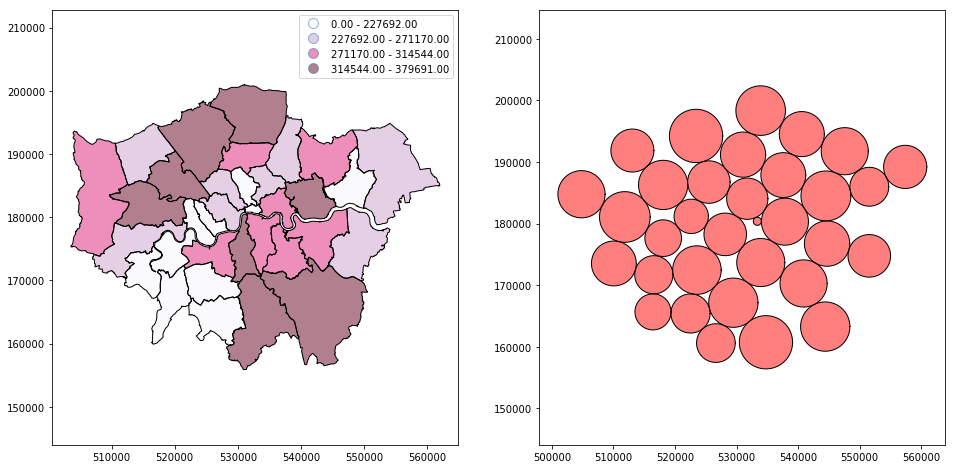

In [4]:
# Map the outcome
fig, ax = plt.subplots(1,2,figsize=(16,8))
ldn_boro.plot(column = 2015,cmap = 'PuRd', scheme = 'Quantiles', k=4,legend=True, ax=ax[0])
ldn_dorling.plot(color='r',ax=ax[1])
ax[0].axis('equal')
ax[1].axis('equal')

In [5]:
# Get some data for US States
usstate = gpd.read_file('data/US_State_2016_5m.geojson')

# Set crs
usstate.crs = {'init': u'epsg:4269'}

# Get continental US and project to NAD83 Contiguous US Albers.
usstate = usstate[~usstate['STUSPS'].isin(['AK', 'HI', 'AS', 'PR',
                                           'GU', 'MP', 'VI'])].to_crs({'init': 'epsg:5070'})
# Read in state populations
state_pop = pd.read_excel('data/Pandas_US_Pop.xlsx')

# Merge population data
usstate = usstate.merge(state_pop, how='left', left_on='STUSPS', right_on='Code')

In [6]:
# Adding id_field variable for labelling purposes
us_dorling = dorling_cartogram(usstate,2016,id_field='STUSPS',iterations=350,verbose=False)

(-3066934.8808599925,
 2960141.9939053734,
 -375088.68707011954,
 3794968.1741067013)

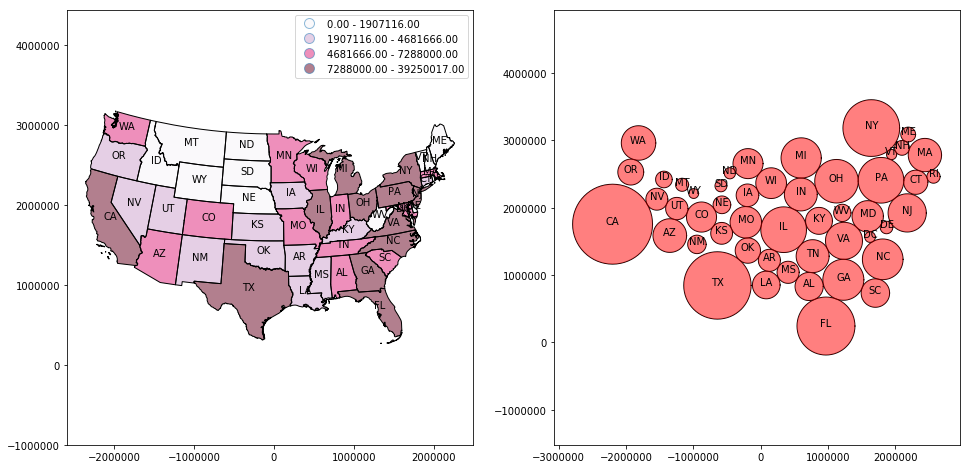

In [7]:
# Map the outcome, the mid-west is v. sparsely populated hence the isolated bubbles.
# This actually works quite well.
fig, ax = plt.subplots(1,2,figsize=(16,8))
usstate.plot(column = 2016,cmap = 'PuRd', scheme = 'Quantiles', k=4,legend=True, ax=ax[0])
# label the areas
usstate.apply(lambda x: ax[0].annotate(s=x['Code'], xy=x['geometry'].centroid.coords[0], ha='center',zorder=1),axis=1)
us_dorling.plot(color='r',ax=ax[1],zorder=0)
# label the bubbles
us_dorling.apply(lambda x: ax[1].annotate(s=x['STUSPS'], xy=x['geometry'].centroid.coords[0], ha='center',zorder=1),axis=1)
ax[0].axis('equal')
ax[1].axis('equal')

In [8]:
# Let's have a look at some other options for starting positions.

# population weighted centers
# Get population-weighted centroid coordinates from US Census website
url = r'https://www2.census.gov/geo/docs/reference/cenpop2010/CenPop2010_Mean_ST.txt'
pop_cent = pd.read_csv(url)
# Convert longitude and latitude fields to shapely point features
pop_cent['pwc'] = pop_cent.apply(lambda x: Point(x['LONGITUDE'],x['LATITUDE']), axis=1)
# Make the dataframe a geodataframe
pop_cent = gpd.GeoDataFrame(pop_cent,geometry=pop_cent['pwc'])
# set coordinate reference system
pop_cent.crs = {'init': u'epsg:4269'}
# Project to NAD83 Contiguous US Albers.
pop_cent = pop_cent.to_crs({'init': 'epsg:5070'})
# Update population-weighted centroids field
pop_cent['pwc'] = pop_cent['geometry']
# Merge with US States file.
# Make matching columns equivalent datatypes
usstate['STATEFP'] = pd.to_numeric(usstate['STATEFP'], downcast='signed')
# Merge population data
usstate = usstate.merge(pop_cent[['STATEFP','pwc']], how='left', on='STATEFP')


# Pass the pwc field to position to initialize Dorling cartogram at population-weighted centroids.
us_dorling_w = dorling_cartogram(usstate,2016,id_field='STUSPS',position = 'pwc',iterations=400,verbose=False)
print('Population-weighted centroids done')
# bounding box centers
us_dorling_c = dorling_cartogram(usstate,2016,id_field='STUSPS',position = 'center',iterations=400,verbose=False)
print('Bounding box centers done')
# representative points
us_dorling_r = dorling_cartogram(usstate,2016,id_field='STUSPS',position = 'rep',iterations=400,verbose=False)
print('Representative point centers done')

Population-weighted centroids done
Bounding box centers done
Representative point centers done


(-3145611.2770791873,
 2963929.2470781063,
 -577973.41147659055,
 3810559.4596415912)

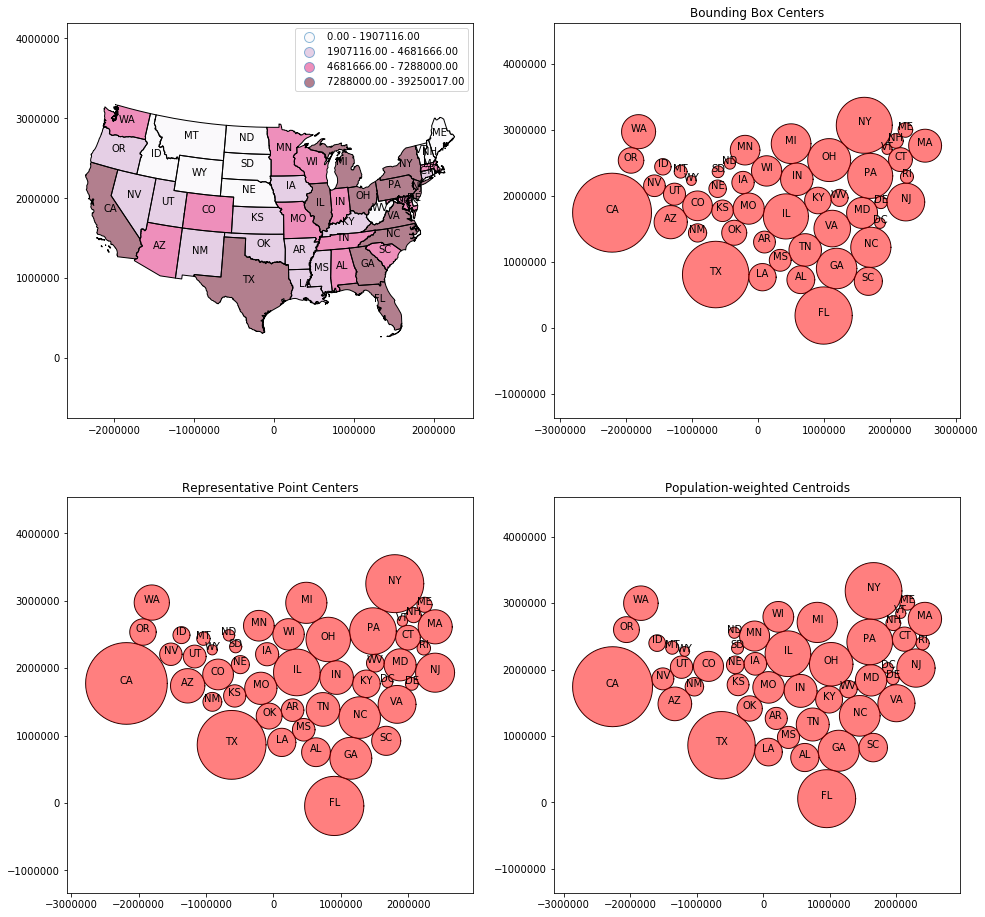

In [9]:
# Map the outcomes, different starting positions create slightly different solutions.
fig, ax = plt.subplots(2,2,figsize=(16,16))
usstate.plot(column = 2016,cmap = 'PuRd', scheme = 'Quantiles', k=4,legend=True, ax=ax[0,0])
# label the areas
usstate.apply(lambda x: ax[0,0].annotate(s=x['Code'], xy=x['geometry'].centroid.coords[0], ha='center',zorder=1),axis=1)

# Bounding box centers
us_dorling_c.plot(color='r',ax=ax[0,1],zorder=0)
# label the bubbles
us_dorling_c.apply(lambda x: ax[0,1].annotate(s=x['STUSPS'], xy=x['geometry'].centroid.coords[0], ha='center',zorder=1),axis=1)
ax[0,1].set_title("Bounding Box Centers")

# Representative point centers
us_dorling_r.plot(color='r',ax=ax[1,0],zorder=0)
# label the bubbles
us_dorling_r.apply(lambda x: ax[1,0].annotate(s=x['STUSPS'], xy=x['geometry'].centroid.coords[0], ha='center',zorder=1),axis=1)
ax[1,0].set_title("Representative Point Centers")

# Population-weighted centroids
us_dorling_w.plot(color='r',ax=ax[1,1],zorder=0)
# label the bubbles
us_dorling_w.apply(lambda x: ax[1,1].annotate(s=x['STUSPS'], xy=x['geometry'].centroid.coords[0], ha='center',zorder=1),axis=1)
ax[1,1].set_title("Population-weighted Centroids")

ax[0,0].axis('equal')
ax[0,1].axis('equal')
ax[1,0].axis('equal')
ax[1,1].axis('equal')